# New

In [15]:
import os
import zipfile
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import gc
import argparse
import time
import pandas as pd
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm
from torchmetrics import JaccardIndex
import shutil
from torchvision import models
from torchsummary import summary
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [14]:
# Define function to extract the dataset from ZIP
def extract_zip(zip_path, extract_to):
    """
    Extracts a ZIP file to the specified directory.
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Dataset extracted to: {extract_to}")

# Path to the ZIP file and extraction directory
zip_file_path = 'archive_3.zip'
extracted_data_path = 'extracted_dataset'

# Call the function to extract the ZIP file
extract_zip(zip_file_path, extracted_data_path)

Dataset extracted to: extracted_dataset


In [16]:
H = 448
W = 448

In [52]:
from collections import namedtuple
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
Label = namedtuple( 'Label' , ['name' ,'id','color'] )
labels = [
    Label(  'ground'  ,  0 ,  (0,  0,  0)     ),
    Label(  'crack'   ,  1 ,  (255, 255, 255) )
]

max_label_id = max([l.id for l in labels])

# turn to arr of numbers between 0 to 1
LabelCmap = colors.ListedColormap([np.array(l.color) / 255 for l in labels])
bounds = np.linspace(0, max_label_id, len(labels))

def display(display_list):
  fig, cols = plt.subplots(1, len(display_list), sharey=True)
  fig.set_size_inches(15, 5)
  title = ['Input Image', 'Ground-truth Labels', 'Stage 1 Prediction Labels']
  im = None
  for i in range(len(display_list)):
    cols[i].set_title(title[i])
    y = display_list[i]
    
    if 'Label' in title[i]:
      w,h,_ = y.shape
      y = y.reshape(w,h)
      im = cols[i].imshow(y, cmap=LabelCmap, vmin=0, vmax=max_label_id)
    else:
      im = cols[i].imshow(tf.keras.preprocessing.image.array_to_img(y)) # this look better
      #im = cols[i].imshow(y)
    cols[i].axis('off')
  cbar = plt.colorbar(im, ax=cols.ravel().tolist(), cmap=LabelCmap, norm=colors.BoundaryNorm(bounds, LabelCmap.N), 
                      orientation='horizontal',spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')
  cbar.ax.set_xticklabels([l.name for l in labels], rotation=90)
  plt.show()

In [77]:
# Plotting Loss, IoU, and Correct in separate subplots
def plot_combined_metrics(train_loss, val_loss, train_iou, val_iou, train_correct, val_correct, save_path='metrics_plot.png'):
    epochs = range(1, len(train_loss) + 1)

    # Create subplots for Loss, IoU, and Correct Predictions
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

    # Plotting Loss
    ax1.plot(epochs, train_loss, label='Training Loss', color='tab:blue', linestyle='-')
    ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', linestyle='--')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plotting IoU
    ax2.plot(epochs, train_iou, label='Training IoU', color='tab:green', linestyle='-')
    ax2.plot(epochs, val_iou, label='Validation IoU', color='tab:red', linestyle='--')
    ax2.set_title('IoU Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.legend()

    # Plotting Correct Predictions
    ax3.plot(epochs, train_correct, label='Training mPA', color='tab:purple', linestyle='-')
    ax3.plot(epochs, val_correct, label='Validation mPA', color='tab:brown', linestyle='--')
    ax3.set_title('Mean Pixel Accuracy (mPA) Over Epochs')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('mPA')
    ax3.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(save_path)
    plt.close()  # Close the plot to free memory

In [60]:
from torchvision import transforms, datasets
import os
import os.path as osp
import random
from glob import glob
from PIL import Image
import scipy.io as scio
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import torch

class CrackDataSet(torch.utils.data.Dataset):
    # data[0] is image, data[1] is mask
    def __init__(self, data, data_transforms):
        self.data_transforms = data_transforms
        self.data = data
        
    def __len__(self):
        return len(self.data[0]) # images size
        
    def __getitem__(self, index):
        # OpenCV's default = BGR => RGB and then adding normalization here
        image = cv2.imread(self.data[0][index], cv2.IMREAD_COLOR)
        image = self.data_transforms(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8'), 'RGB'))

        # masks are black and white images, so pixels closer to 255 consider = crack = label them
        mask = cv2.imread(self.data[1][index], cv2.IMREAD_GRAYSCALE)
        mask_label = np.zeros(mask.shape)
        mask_label[mask >= 128] = 1
        mask_label = np.asarray(mask_label, np.compat.long)
        mask_label = torch.LongTensor(mask_label)
        return image, mask_label

In [66]:
import argparse
import os
import time
import pandas as pd
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm
from torchmetrics import JaccardIndex
import shutil
from torchvision import models
from torchsummary import summary

def load_data(path=''):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))
    train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (valid_x, valid_y)

class Trainer_Wrapper():
    def __init__(self, model, input_path, batch_size, max_epochs, num_class=2):
        self.num_class = num_class
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.epoch = 1
        self.max_epochs = max_epochs
        self.lr = 0.001
        data_train, data_eval = load_data(path=input_path)
        self.image_datasets = {
            'train': CrackDataSet(data_train, data_transforms['train']),
            'validation': CrackDataSet(data_eval, data_transforms['validation'])
        }
        self.train_loader = torch.utils.data.DataLoader(self.image_datasets['train'],
                                                        batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(self.image_datasets['validation'],
                                                      batch_size=batch_size, shuffle=False)
        self.model = model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scaler = torch.amp.GradScaler('cuda')  # Add mixed precision scaler

        self.fiou = JaccardIndex(task='multiclass', num_classes=self.num_class).to(self.device)
        self.loss_criterion = nn.CrossEntropyLoss()
        self.train_loss_history, self.train_iou_history, self.train_correct_history = [], [], []
        self.eval_loss_history, self.eval_iou_history, self.eval_correct_history = [], [], []

    def begin_train(self):
        for self.epoch in range(1, self.max_epochs + 1):
            self.training()
            self.evaluate_epoch('Validation', self.val_loader)
            
            # Clear memory after each epoch
            torch.cuda.empty_cache()
            gc.collect()

        plot_combined_metrics(
            self.train_loss_history, self.eval_loss_history,
            self.train_iou_history, self.eval_iou_history,
            self.train_correct_history, self.eval_correct_history
        )

    def training(self):
        self.model.train()
        total_correct, total_iou, total_loss, total_num_of_images = 0.0, 0.0, 0.0, 0.0
        num_of_batches = 0

        for data, target in tqdm(self.train_loader, desc=f"Training Epoch {self.epoch}/{self.max_epochs}"):
            num_of_batches += 1
            data, target = data.to(self.device), target.to(self.device)

            with torch.amp.autocast('cuda'):  # Enable mixed precision
                out = self.model(data)['out']
                loss = self.loss_criterion(out, target)

            # Backpropagation with scaled gradients
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            # Update metrics
            prediction = torch.argmax(out, dim=1)
            num_of_samples = data.size(0)
            total_loss += loss.item() * num_of_samples
            total_iou += self.fiou(out, target).item()
            total_num_of_images += num_of_samples
            total_correct += torch.sum(prediction == target).item() / target.numel() * num_of_samples

            # Clear memory after each batch
            torch.cuda.empty_cache()
            gc.collect()

        avg_loss = total_loss / total_num_of_images
        avg_iou = total_iou / num_of_batches
        avg_correct = total_correct / total_num_of_images

        self.train_loss_history.append(avg_loss)
        self.train_iou_history.append(avg_iou)
        self.train_correct_history.append(avg_correct)

        print(f"Training - Epoch [{self.epoch}/{self.max_epochs}] - "
              f"Loss: {avg_loss:.4f} | mPA: {avg_correct * 100:.2f}% | IoU: {avg_iou:.4f}")

    def evaluate_epoch(self, epoch_mode, loader):
        self.model.eval()
        total_iou, total_loss, total_correct, total_num_of_images = 0.0, 0.0, 0.0, 0
        num_of_batches = 0

        with torch.no_grad():  # Disable gradient calculation during evaluation
            for data, target in tqdm(loader, desc=f"Evaluating {epoch_mode}"):
                num_of_batches += 1
                data, target = data.to(self.device), target.to(self.device)

                out = self.model(data)['out']
                prediction = torch.argmax(out, dim=1)

                # Calculate loss, IoU, and correct predictions
                loss = self.loss_criterion(out, target)
                num_of_samples = data.size(0)
                total_loss += loss.item() * num_of_samples
                total_iou += self.fiou(out, target).item()
                total_num_of_images += num_of_samples
                total_correct += torch.sum(prediction == target).item() / target.numel() * num_of_samples

        # Use safe division to prevent division by zero
        avg_loss = total_loss / total_num_of_images if total_num_of_images > 0 else 0
        avg_iou = total_iou / num_of_batches if num_of_batches > 0 else 0
        avg_correct = total_correct / total_num_of_images if total_num_of_images > 0 else 0

        # Append metrics to history lists
        if epoch_mode == 'Training':
            self.train_loss_history.append(avg_loss)
            self.train_iou_history.append(avg_iou)
            self.train_correct_history.append(avg_correct)
        else:
            self.eval_loss_history.append(avg_loss)
            self.eval_iou_history.append(avg_iou)
            self.eval_correct_history.append(avg_correct)

        print(f"{epoch_mode} - Epoch [{self.epoch}/{self.max_epochs}] - "
              f"Loss: {avg_loss:.4f} | mPA: {avg_correct * 100:.2f}% | IoU: {avg_iou:.4f}")

        # Clear memory after evaluation
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
import gc

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [67]:
import torch
torch.cuda.empty_cache()  # Clear cached memory
gc.collect()

4523

In [68]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

input_path = 'extracted_dataset/crack_segmentation_dataset'
batch_size = 8
max_epochs = 25
num_of_classes = 2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(), normalize]),
    'validation': transforms.Compose([transforms.ToTensor(), normalize]),
}

In [69]:
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights, deeplabv3_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def custom_DeepLabv3():
    # Load the pretrained weights
    weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1

    # Load the model with default weights (21 classes)
    model = deeplabv3_resnet50(weights=weights, progress=True)

    # Replace the classifier to fit 2 classes (ground, crack)
    model.classifier = DeepLabHead(2048, 2)

    model.train()
    return model

Training Epoch 1/25: 100%|██████████| 1130/1130 [13:55<00:00,  1.35it/s]


Training - Epoch [1/25] - Loss: 0.0784 | mPA: 97.11% | IoU: 0.6760


Evaluating Validation: 100%|██████████| 283/283 [03:03<00:00,  1.54it/s]


Validation - Epoch [1/25] - Loss: 0.0627 | mPA: 97.69% | IoU: 0.7036


Training Epoch 2/25: 100%|██████████| 1130/1130 [13:58<00:00,  1.35it/s]


Training - Epoch [2/25] - Loss: 0.0603 | mPA: 97.73% | IoU: 0.7241


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [2/25] - Loss: 0.0639 | mPA: 97.58% | IoU: 0.7214


Training Epoch 3/25: 100%|██████████| 1130/1130 [13:58<00:00,  1.35it/s]


Training - Epoch [3/25] - Loss: 0.0575 | mPA: 97.80% | IoU: 0.7315


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [3/25] - Loss: 0.0556 | mPA: 97.87% | IoU: 0.7448


Training Epoch 4/25: 100%|██████████| 1130/1130 [13:53<00:00,  1.36it/s]


Training - Epoch [4/25] - Loss: 0.0547 | mPA: 97.88% | IoU: 0.7392


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [4/25] - Loss: 0.0587 | mPA: 97.72% | IoU: 0.7274


Training Epoch 5/25: 100%|██████████| 1130/1130 [13:50<00:00,  1.36it/s]


Training - Epoch [5/25] - Loss: 0.0536 | mPA: 97.91% | IoU: 0.7430


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [5/25] - Loss: 0.0587 | mPA: 97.81% | IoU: 0.7429


Training Epoch 6/25: 100%|██████████| 1130/1130 [13:51<00:00,  1.36it/s]


Training - Epoch [6/25] - Loss: 0.0524 | mPA: 97.95% | IoU: 0.7456


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [6/25] - Loss: 0.0533 | mPA: 97.98% | IoU: 0.7441


Training Epoch 7/25: 100%|██████████| 1130/1130 [13:52<00:00,  1.36it/s]


Training - Epoch [7/25] - Loss: 0.0508 | mPA: 97.99% | IoU: 0.7498


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [7/25] - Loss: 0.0514 | mPA: 98.00% | IoU: 0.7575


Training Epoch 8/25: 100%|██████████| 1130/1130 [13:52<00:00,  1.36it/s]


Training - Epoch [8/25] - Loss: 0.0495 | mPA: 98.02% | IoU: 0.7550


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [8/25] - Loss: 0.0517 | mPA: 97.98% | IoU: 0.7485


Training Epoch 9/25: 100%|██████████| 1130/1130 [13:57<00:00,  1.35it/s]


Training - Epoch [9/25] - Loss: 0.0486 | mPA: 98.05% | IoU: 0.7574


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [9/25] - Loss: 0.0552 | mPA: 97.88% | IoU: 0.7506


Training Epoch 10/25: 100%|██████████| 1130/1130 [13:47<00:00,  1.37it/s]


Training - Epoch [10/25] - Loss: 0.0471 | mPA: 98.08% | IoU: 0.7614


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [10/25] - Loss: 0.0505 | mPA: 98.02% | IoU: 0.7510


Training Epoch 11/25: 100%|██████████| 1130/1130 [13:49<00:00,  1.36it/s]


Training - Epoch [11/25] - Loss: 0.0468 | mPA: 98.08% | IoU: 0.7614


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [11/25] - Loss: 0.0497 | mPA: 98.07% | IoU: 0.7528


Training Epoch 12/25: 100%|██████████| 1130/1130 [13:53<00:00,  1.35it/s]


Training - Epoch [12/25] - Loss: 0.0458 | mPA: 98.11% | IoU: 0.7652


Evaluating Validation: 100%|██████████| 283/283 [03:02<00:00,  1.55it/s]


Validation - Epoch [12/25] - Loss: 0.0521 | mPA: 98.03% | IoU: 0.7570


Training Epoch 13/25: 100%|██████████| 1130/1130 [13:47<00:00,  1.37it/s]


Training - Epoch [13/25] - Loss: 0.0446 | mPA: 98.15% | IoU: 0.7682


Evaluating Validation: 100%|██████████| 283/283 [03:01<00:00,  1.56it/s]


Validation - Epoch [13/25] - Loss: 0.0556 | mPA: 98.02% | IoU: 0.7558


Training Epoch 14/25: 100%|██████████| 1130/1130 [13:52<00:00,  1.36it/s]


Training - Epoch [14/25] - Loss: 0.0443 | mPA: 98.15% | IoU: 0.7694


Evaluating Validation: 100%|██████████| 283/283 [03:01<00:00,  1.56it/s]


Validation - Epoch [14/25] - Loss: 0.0487 | mPA: 98.10% | IoU: 0.7604


Training Epoch 15/25: 100%|██████████| 1130/1130 [13:43<00:00,  1.37it/s]


Training - Epoch [15/25] - Loss: 0.0436 | mPA: 98.17% | IoU: 0.7711


Evaluating Validation: 100%|██████████| 283/283 [03:01<00:00,  1.56it/s]


Validation - Epoch [15/25] - Loss: 0.0496 | mPA: 98.04% | IoU: 0.7603


Training Epoch 16/25: 100%|██████████| 1130/1130 [13:42<00:00,  1.37it/s]


Training - Epoch [16/25] - Loss: 0.0425 | mPA: 98.20% | IoU: 0.7749


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [16/25] - Loss: 0.0484 | mPA: 98.11% | IoU: 0.7651


Training Epoch 17/25: 100%|██████████| 1130/1130 [13:38<00:00,  1.38it/s]


Training - Epoch [17/25] - Loss: 0.0412 | mPA: 98.24% | IoU: 0.7786


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [17/25] - Loss: 0.0493 | mPA: 98.07% | IoU: 0.7675


Training Epoch 18/25: 100%|██████████| 1130/1130 [13:39<00:00,  1.38it/s]


Training - Epoch [18/25] - Loss: 0.0409 | mPA: 98.25% | IoU: 0.7807


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [18/25] - Loss: 0.0486 | mPA: 98.06% | IoU: 0.7649


Training Epoch 19/25: 100%|██████████| 1130/1130 [13:42<00:00,  1.37it/s]


Training - Epoch [19/25] - Loss: 0.0398 | mPA: 98.28% | IoU: 0.7842


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.56it/s]


Validation - Epoch [19/25] - Loss: 0.0518 | mPA: 98.00% | IoU: 0.7612


Training Epoch 20/25: 100%|██████████| 1130/1130 [13:39<00:00,  1.38it/s]


Training - Epoch [20/25] - Loss: 0.0398 | mPA: 98.29% | IoU: 0.7845


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [20/25] - Loss: 0.0482 | mPA: 98.08% | IoU: 0.7679


Training Epoch 21/25: 100%|██████████| 1130/1130 [13:39<00:00,  1.38it/s]


Training - Epoch [21/25] - Loss: 0.0389 | mPA: 98.32% | IoU: 0.7868


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [21/25] - Loss: 0.0492 | mPA: 98.08% | IoU: 0.7626


Training Epoch 22/25: 100%|██████████| 1130/1130 [13:38<00:00,  1.38it/s]


Training - Epoch [22/25] - Loss: 0.0380 | mPA: 98.35% | IoU: 0.7907


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [22/25] - Loss: 0.0496 | mPA: 98.10% | IoU: 0.7695


Training Epoch 23/25: 100%|██████████| 1130/1130 [13:38<00:00,  1.38it/s]


Training - Epoch [23/25] - Loss: 0.0374 | mPA: 98.37% | IoU: 0.7929


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [23/25] - Loss: 0.0497 | mPA: 98.13% | IoU: 0.7633


Training Epoch 24/25: 100%|██████████| 1130/1130 [13:36<00:00,  1.38it/s]


Training - Epoch [24/25] - Loss: 0.0373 | mPA: 98.37% | IoU: 0.7931


Evaluating Validation: 100%|██████████| 283/283 [03:00<00:00,  1.57it/s]


Validation - Epoch [24/25] - Loss: 0.0510 | mPA: 98.04% | IoU: 0.7640


Training Epoch 25/25: 100%|██████████| 1130/1130 [13:37<00:00,  1.38it/s]


Training - Epoch [25/25] - Loss: 0.0368 | mPA: 98.39% | IoU: 0.7953


Evaluating Validation: 100%|██████████| 283/283 [02:59<00:00,  1.57it/s]


Validation - Epoch [25/25] - Loss: 0.0491 | mPA: 98.11% | IoU: 0.7645


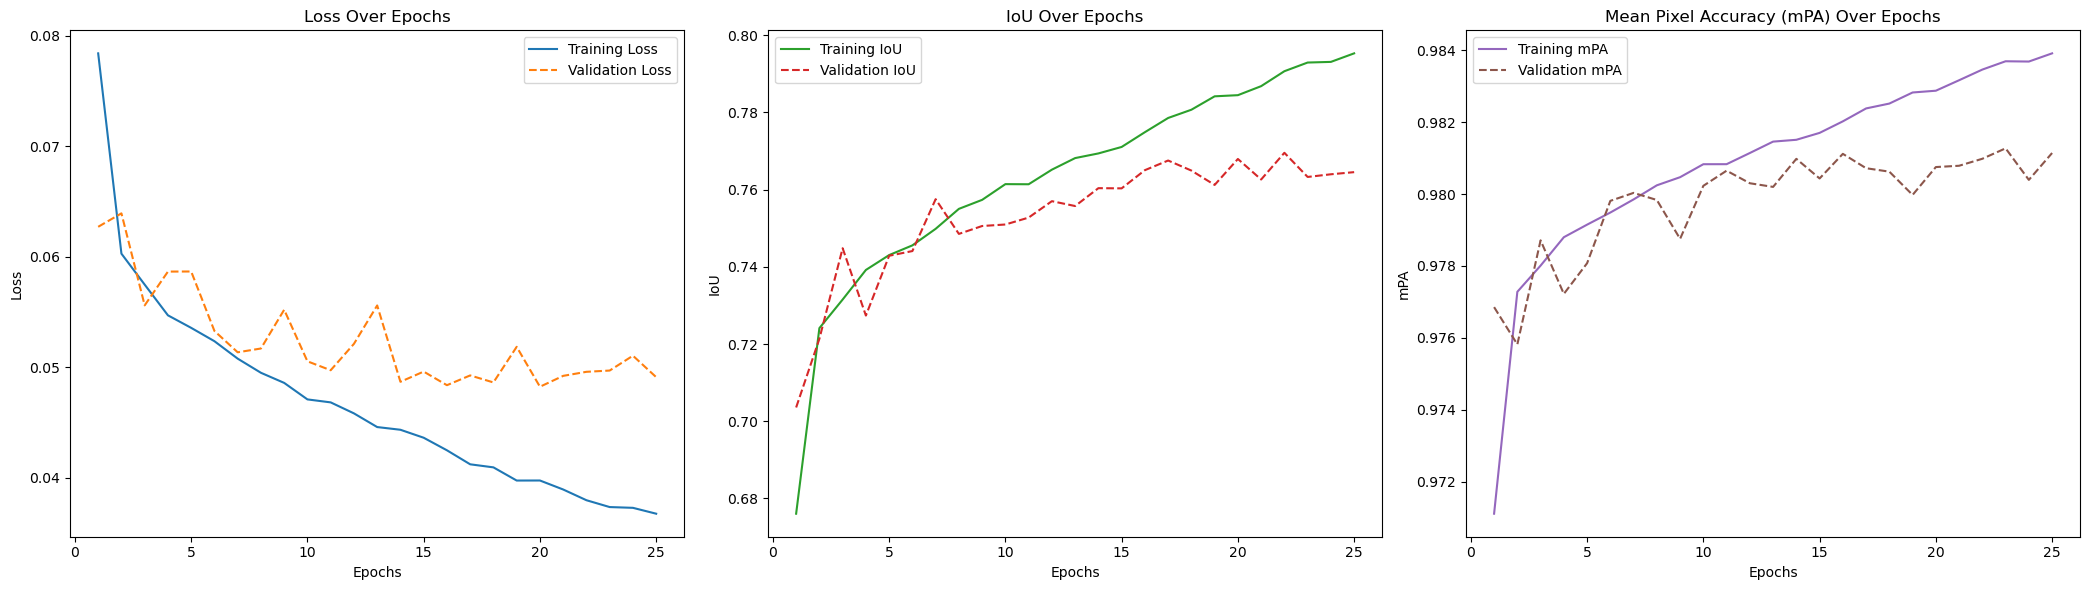

RuntimeError: Parent directory extracted_dataset/crack_segmentation_dataset/weights does not exist.

In [ ]:
from torch.cuda.amp import GradScaler, autocast

model = custom_DeepLabv3()
trainer = Trainer_Wrapper(model, input_path, batch_size, max_epochs, num_of_classes)
trainer.begin_train()

weight_dir = input_path + "/weights"
filename = 'res_net_best_weight.pth'
save_path = os.path.join(weight_dir, filename)
torch.save(trainer.model.state_dict(), save_path)

In [76]:
from torch.cuda.amp import GradScaler, autocast


weight_dir = "extracted_dataset/crack_segmentation_dataset/weights"
filename = 'res_net_best_weight.pth'
save_path = os.path.join(weight_dir, filename)
torch.save(trainer.model.state_dict(), save_path)

In [79]:

plot_combined_metrics(
    trainer.train_loss_history, trainer.eval_loss_history,
    trainer.train_iou_history, trainer.eval_iou_history,
    trainer.train_correct_history, trainer.eval_correct_history,
    save_path='training_validation_metrics.png'  # Save the plot as a PNG file
)



In [80]:
import pandas as pd

# Create a DataFrame from the training metrics
metrics_df = pd.DataFrame({
    'Epoch': range(1, len(trainer.train_loss_history) + 1),
    'Train Loss': trainer.train_loss_history,
    'Validation Loss': trainer.eval_loss_history,
    'Train IoU': trainer.train_iou_history,
    'Validation IoU': trainer.eval_iou_history,
    'Train mPA': trainer.train_correct_history,
    'Validation mPA': trainer.eval_correct_history
})

# Export to CSV
metrics_df.to_csv('training_metrics_report.csv', index=False)

print("Metrics exported to 'training_metrics_report.csv'")


Metrics exported to 'training_metrics_report.csv'
